In [1]:
device = None

## for TPU
## https://www.kaggle.com/abhinand05/vision-transformer-vit-tutorial-baseline
#import os
#if os.path.exists("./torchvision-1.7-cp37-cp37m-linux_x86_64.whl") == False:
#    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#    !python pytorch-xla-env-setup.py --version 1.7
#import torch_xla
#import torch_xla.core.xla_model as xm
#import torch_xla.distributed.xla_multiprocessing as xmp
#import torch_xla.distributed.parallel_loader as pl
#device = xm.xla_device()
#num_workers = 2  # os.cpu_count()  # 4

# for GPU
if device is None:
    import os
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if os.getcwd() in ["/kaggle/working", "/content"]:
        num_workers = os.cpu_count()  # 4
    else:
        num_workers = 0
    
print("device:", device)

device: cuda


In [2]:
import os, sys
if os.getcwd() in ["/kaggle/working", "/content"]:
    !pip install "../input/pytorchlightning110/pytorch_lightning-1.1.0-py3-none-any.whl"
    !pip install pytorch-gradcam
    !pip install torch_optimizer
    !pip install adabelief-pytorch==0.1.0
    from gradcam import GradCAM, GradCAMpp
    import torch_optimizer
    from adabelief_pytorch import AdaBelief
else:
    #sys.path.append(r"C:\Users\81908\Git\Adabelief-Optimizer\pypi_packages\adabelief_pytorch0.1.0")
    #from adabelief_pytorch import AdaBelief
    #sys.path.append(r"C:\Users\81908\Git\gradcam_plus_plus-pytorch")
    #from gradcam import GradCAM, GradCAMpp
    pass

In [3]:
import sys
if os.getcwd() in ["/kaggle/working", "/content"]:
    sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
import timm
print("timm version:", timm.__version__)

timm version: 0.3.2


In [4]:
# https://rwightman.github.io/pytorch-image-models/
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

# imagenetの精度一覧
# https://sotabench.com/user/rwightman/repos/rwightman/pytorch-image-models

['adv_inception_v3',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_lite0',
 'ens_adv_inception_resnet_v2',
 'ese_vovnet19b_dw',
 'ese_vovnet39b',
 'fbnetc_100',
 'gluon_inception_v3',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resnet50_v1s',
 'gluon_resn

In [5]:
import os, sys
if os.getcwd() in ["/kaggle/working", "/content"]:
    sys.path.append("../input/cleanlab/")
import cleanlab
from cleanlab.classification import LearningWithNoisyLabels
print("cleanlab version:", cleanlab.__version__)

cleanlab version: 0.1.1


In [6]:
import os, sys
if os.getcwd() in ["/kaggle/working", "/content"]:
    if not os.path.exists('./kaggle_Cassava'):
        !git clone https://github.com/riron1206/kaggle_Cassava.git    
    sys.path.append("./kaggle_Cassava/code")
else:
    #sys.path.append(r"C:\Users\81908\MyGitHub\kaggle_Cassava\code")
    sys.path.append(r"C:\Users\shingo\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\kaggle_Cassava\code")

from gem_pooling import GeM, GeMNet
from bi_tempered_loss import BiTemperedLoss
from symmetric_ce_loss import SymmetricCrossEntropyLoss
from mix_aug import cutmix, fmix, snapmix, SnapMixLoss
from sampling import minor_class_over_sample, imblearn_over_sampling, imblearn_under_sampling
from my_lr_scheduler import _CosineAnnealingWarmupRestarts
from balanced_batch_sampler import BalancedBatchSampler
#from gradcam_util import GradcamUtil
from util_torch import freeze_until, freeze_bn
from visualize import visualize_transpose, show_images, show_pred_diff_images
from sharpen import sharpen
from dataset_normalize_param import dataset_normalize_param

In [7]:
import os
import random
import torch


def set_seed(seed: int=42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [8]:
# https://www.kaggle.com/mekhdigakhramanian/pytorch-efficientnet-baseline-inference-tta/data?select=tf_efficientnet_b3_ns_fold_0_0
import torch
import numpy as np


def inference_one_epoch(model, data_loader, device):
    model.eval()
    image_preds_all = []
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            imgs = batch["x"].to(device).float()
            model = model.to(device)
            image_preds = model(imgs)
            image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [9]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from colorama import Fore
r_ = Fore.RED
b_ = Fore.BLUE
y_ = Fore.YELLOW


def check_oof(y):
    Y_oof = pickle.load(open(f"Y_pred.pkl", 'rb'))
    Y_tta_oof = pickle.load(open(f"Y_pred_tta.pkl", 'rb'))
    oof = accuracy_score(y, Y_oof.values.argmax(1))
    oof_tta = accuracy_score(y, Y_tta_oof.values.argmax(1))    
    oof_loss = log_loss(y, Y_oof.values)
    oof_loss_tta = log_loss(y, Y_tta_oof.values)
    print(y_, f"oof:", round(oof, 4)) 
    print(y_, f"oof_tta:", round(oof_tta, 4))
    print(y_, f"oof_loss:", round(oof_loss, 4))
    print(y_, f"oof_loss_tta:", round(oof_loss_tta, 4))
    return oof, oof_tta, oof_loss, oof_loss_tta

In [10]:
import os
import cv2
import glob
import random
import shutil
import pickle
import json
import yaml
import pathlib
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda import amp

import torchvision
from torchvision import models

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

import wandb

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.loggers.wandb import WandbLogger

import warnings

warnings.filterwarnings("ignore")

print("pytorch_lightning version:", pl.__version__)

pytorch_lightning version: 1.1.0


In [11]:
import os, shutil
if os.path.exists("lightning_logs/"):
    shutil.rmtree("lightning_logs/")
    os.mkdir("lightning_logs/")
if os.path.exists("wandb/"):
    shutil.rmtree("wandb/")

# Data

In [12]:
if os.getcwd() in "/kaggle/working":
    ROOT_DIR = "../input/cassava-leaf-disease-classification"
    TRAIN_DIR = "../input/cassava-leaf-disease-classification/train_images"
    TEST_DIR = "../input/cassava-leaf-disease-classification/test_images"
    
elif os.getcwd() in "/content":
    ROOT_DIR = "/content/drive/MyDrive/competitions/cassava"
    TRAIN_DIR = "/content/drive/MyDrive/competitions/cassava/train_images"
    TEST_DIR = "/content/drive/MyDrive/competitions/cassava/test_images"
    
else:
    #OOT_DIR = r"C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification"
    #RAIN_DIR = r"C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\train_images"
    #EST_DIR = r"C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\test_images"
    ROOT_DIR = r"C:\Users\shingo\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification"
    TRAIN_DIR = r"C:\Users\shingo\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\train_images"
    TEST_DIR = r"C:\Users\shingo\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\test_images"
    
with open(f"{ROOT_DIR}/label_num_to_disease_map.json", "r") as f:
    name_mapping = json.load(f)
name_mapping = {int(k): v for k, v in name_mapping.items()}
print(name_mapping)


df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df["file_path"] = f"{TRAIN_DIR}/" + df["image_id"]
onehot_label = np.identity(len(name_mapping))[df["label"].values]
onehot_label = pd.DataFrame(onehot_label, columns=name_mapping.values())
df = df.join(onehot_label)
df["logit"] = 1.0
print(df.shape)
display(df)


test_df = pd.read_csv(f"{ROOT_DIR}/sample_submission.csv")
test_df["file_path"] = f"{TEST_DIR}/" + test_df["image_id"]
onehot_label = np.identity(len(name_mapping))[test_df["label"].values]
onehot_label = pd.DataFrame(onehot_label, columns=name_mapping.values())
test_df = test_df.join(onehot_label)
test_df["logit"] = 1.0

{0: 'Cassava Bacterial Blight (CBB)', 1: 'Cassava Brown Streak Disease (CBSD)', 2: 'Cassava Green Mottle (CGM)', 3: 'Cassava Mosaic Disease (CMD)', 4: 'Healthy'}
(21397, 9)


,image_id,label,file_path,Cassava Bacterial Blight (CBB),Cassava Brown Streak Disease (CBSD),Cassava Green Mottle (CGM),Cassava Mosaic Disease (CMD),Healthy,logit
0,1000015157.jpg,0,C:\Users\shingo\jupyter_notebook\pytorch_light...,1.0,0.0,0.0,0.0,0.0,1.0
1,1000201771.jpg,3,C:\Users\shingo\jupyter_notebook\pytorch_light...,0.0,0.0,0.0,1.0,0.0,1.0
2,100042118.jpg,1,C:\Users\shingo\jupyter_notebook\pytorch_light...,0.0,1.0,0.0,0.0,0.0,1.0
3,1000723321.jpg,1,C:\Users\shingo\jupyter_notebook\pytorch_light...,0.0,1.0,0.0,0.0,0.0,1.0
4,1000812911.jpg,3,C:\Users\shingo\jupyter_notebook\pytorch_light...,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
21392,999068805.jpg,3,C:\Users\shingo\jupyter_notebook\pytorch_light...,0.0,0.0,0.0,1.0,0.0,1.0
21393,999329392.jpg,3,C:\Users\shingo\jupyter_notebook\pytorch_light...,0.0,0.0,0.0,1.0,0.0,1.0
21394,999474432.jpg,1,C:\Users\shingo\jupyter_notebook\pytorch_light...,0.0,1.0,0.0,0.0,0.0,1.0
21395,999616605.jpg,4,C:\Users\shingo\jupyter_notebook\pytorch_light...,0.0,0.0,0.0,0.0,1.0,1.0


# Dataset, Lightning Data Module

In [13]:
class CassavaDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        train: bool = True,
        transforms=None,
    ):
        self.df = df
        self.train = train
        self.transforms = transforms

    def __getitem__(self, index):
        im_path = self.df.iloc[index]["file_path"]
        x = cv2.imread(im_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

        if self.transforms:
            x = self.transforms(image=x)["image"]

        if self.train:
            y = self.df.iloc[index]["label"]
            y_soft = self.df.iloc[index][list(name_mapping.values())].values.astype(np.float32)
            return {"x": x, "y": y, "y_soft": y_soft, "index": index}
        else:
            return {"x": x}

    def __len__(self):
        return len(self.df)


class CassavaDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df,
        valid_df,
        data_transforms,
        CFG,
    ):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.data_transforms = data_transforms
        self.CFG = CFG

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        self.train_dataset = CassavaDataset(
            self.train_df, train=True, transforms=self.data_transforms["train"], 
        )

        self.valid_dataset = CassavaDataset(
            self.valid_df, train=True, transforms=self.data_transforms["valid"],
        )

        self.valid_tta_dataset = CassavaDataset(
            self.valid_df, train=True, transforms=self.data_transforms["test"],
        )  # test setのTTA条件

    def train_dataloader(self):
        if self.CFG.is_balanced_batch:
            assert self.CFG.batch_size % self.CFG.n_classes == 0, 'batch_sizeはクラス数の整数倍にしないとダメ！！！'
            
            balanced_batch_sampler = BalancedBatchSampler(
                self.train_dataset, self.train_df["label"].values
            )

            train_loader = DataLoader(
                self.train_dataset,
                batch_size=self.CFG.batch_size,
                num_workers=self.CFG.num_workers,
                drop_last=True,
                sampler=balanced_batch_sampler,
            )
        else:
            train_loader = DataLoader(
                self.train_dataset,
                batch_size=self.CFG.batch_size,
                num_workers=self.CFG.num_workers,
                drop_last=True,
                shuffle=True,
            )

        return train_loader

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=self.CFG.batch_size,
            num_workers=self.CFG.num_workers,
            shuffle=False,
        )

    def val_tta_dataloader(self):
        return DataLoader(
            self.valid_tta_dataset,
            batch_size=self.CFG.batch_size,
            num_workers=self.CFG.num_workers,
            shuffle=False,
        )

# LightningModule

In [14]:
class CassavaLite(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.use_amp = True  # apex amp を有効にする(16-bit mixed precision) https://pytorch-lightning.readthedocs.io/en/stable/lightning_module.html

        self.net = timm.create_model(CFG.arch, pretrained=True)
        
        if CFG.model_path is not None:
            # 学習済みモデルファイル指定ある場合ロード
            self.net.load_state_dict(torch.load(CFG.model_path))
            print("load pth:", CFG.model_path)

        if "eff" in CFG.arch:
            self.net.classifier = nn.Linear(
                self.net.classifier.in_features, CFG.n_classes
            )
            if CFG.gem_p > 0.0:
                self.net = GeMNet(
                    list(self.net.children())[:-2],
                    GeM(p=CFG.gem_p),
                    self.net.classifier.in_features,
                    CFG.n_classes,
                )
            self.feat_net = nn.Sequential(*list(self.net.children())[:-2])

        elif "rexnet" in CFG.arch:
            self.net.head.fc = nn.Linear(self.net.head.fc.in_features, CFG.n_classes)
            if CFG.gem_p > 0.0:
                self.net = GeMNet(
                    list(self.net.children())[:-1],
                    GeM(p=CFG.gem_p),
                    self.net.head.fc.in_features,
                    CFG.n_classes,
                )
            self.feat_net = nn.Sequential(*list(self.net.children())[:-1])

        elif "vit" in CFG.arch:
            self.net.head = nn.Linear(self.net.head.in_features, CFG.n_classes)
            self.feat_net = nn.Sequential(*list(self.net.children())[:-1])

        else:
            self.net.fc = nn.Linear(self.net.fc.in_features, CFG.n_classes)
            if CFG.gem_p > 0.0:
                self.net = GeMNet(
                    list(self.net.children())[:-2],
                    GeM(p=CFG.gem_p),
                    self.net.fc.in_features,
                    CFG.n_classes,
                )
            self.feat_net = nn.Sequential(
                *list(self.net.children())[:-2]
            )  # global_poolとfc層除く


    def forward(self, x):
        out = self.net(x)
        return out

    def feat_forward(self, x):
        """全結合層の直前の予測値取得用"""
        feat = self.feat_net(x)
        return feat.detach()  # 「detach()」はTensor型から勾配情報を抜いたものを取得

    def configure_optimizers(self):
        param_groups = self.parameters()

        if CFG.opt == "adam":
            optimizer = torch.optim.Adam(
                param_groups,
                lr=CFG.lr,
                weight_decay=CFG.weight_decay,
                amsgrad=False,
            )
        elif CFG.opt == "adabelief":
            optimizer = AdaBelief(
                param_groups, lr=CFG.lr, weight_decay=CFG.weight_decay
            )
        elif CFG.opt == "radam":
            optimizer = torch_optimizer.RAdam(
                param_groups, lr=CFG.lr, weight_decay=CFG.weight_decay
            )
        else:
            optimizer = torch.optim.AdamW(
                param_groups, lr=CFG.lr, weight_decay=CFG.weight_decay
            )

        if CFG.lr_scheduler == "CosineAnnealingLR":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr
            )
        elif CFG.lr_scheduler == "CosineAnnealingWarmRestarts":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=CFG.T_max, T_mult=1, eta_min=CFG.min_lr
            )
        elif CFG.lr_scheduler == "CosineAnnealingWarmUpRestarts":
            scheduler = _CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.max_epochs,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=1,
            )
        else:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=2, gamma=0.1
            )

        return [optimizer], [scheduler]

    def loss(self, y_hat, y, mix_decision):
        if CFG.train_loss_name == "SmoothCrossEntropyLoss":
            loss_fn = SmoothCrossEntropyLoss(smoothing=CFG.smoothing).to(CFG.device)
        elif CFG.train_loss_name == "FocalCosineLoss":
            loss_fn = FocalCosineLoss(smoothing=CFG.smoothing).to(CFG.device)
        elif CFG.train_loss_name == "BiTemperedLoss":
            # labelsmoothing と mix_aug を半々にする
            # https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/209065
            if mix_decision < CFG.mix_decision_th:
                loss_fn = BiTemperedLoss(t1=CFG.t1, t2=CFG.t2, smoothing=0.0).to(CFG.device)
            else:
                loss_fn = BiTemperedLoss(t1=CFG.t1, t2=CFG.t2, smoothing=CFG.smoothing).to(CFG.device)
        elif CFG.train_loss_name == "SymmetricCrossEntropyLoss":
            if mix_decision < CFG.mix_decision_th:
                loss_fn = SymmetricCrossEntropyLoss(
                    num_classes=CFG.n_classes,
                    alpha=CFG.symmetric_alpha,
                    beta=CFG.symmetric_beta,
                    smoothing=0.0).to(CFG.device)
            else:
                loss_fn = SymmetricCrossEntropyLoss(
                    num_classes=CFG.n_classes,
                    alpha=CFG.symmetric_alpha,
                    beta=CFG.symmetric_beta,
                    smoothing=CFG.smoothing).to(CFG.device)
        elif CFG.train_loss_name == "ElrLoss":
            loss_fn = ElrLoss(num_classes=CFG.n_classes).to(CFG.device)
        else:
            loss_fn = nn.CrossEntropyLoss().to(CFG.device)

        # BiTemperedLoss, SymmetricCrossEntropyLoss はソフトラベル可能
        return loss_fn(y_hat, y)

    def training_step(self, batch, batch_idx):
        x, y, y_soft, index = batch["x"], batch["y"], batch["y_soft"], batch["index"].detach().cpu().numpy()
        #print(index, ordered_label_errors)

        # -------- 画像表示 --------
        if DEBUG:
            try:
                fig = plt.figure(figsize=(16, 16))
                for i in range(5):
                    print("y:", y[i])
                    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
                    im = x[i].to("cpu").numpy().transpose(1, 2, 0)
                    plt.imshow(im)
                plt.show()
                plt.clf()
                plt.close()
            except:
                pass
        # -------------------------

        # cutmix/fmix/snapmix
        mix_decision = np.random.rand()
        if mix_decision < CFG.mix_decision_th or len(np.intersect1d(index, ordered_label_errors)) > 0:
            if CFG.mixmethod == "cutmix":
                #print("intersect1d index:", len(np.intersect1d(index, ordered_label_errors)))
                x, y_mixs = cutmix(x, y.long(), CFG.mix_alpha)
                y_hat = self(x.float())
                loss = self.loss(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + self.loss(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])

            elif CFG.mixmethod == "fmix":
                x, y_mixs = fmix(
                    x,
                    y.long(),
                    alpha=CFG.mix_alpha,
                    decay_power=5.0,
                    shape=(CFG.height, CFG.width),
                )
                y_hat = self(x.float())
                loss = self.loss(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + self.loss(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])

            else:
                y_hat = self(x.float())
                if CFG.is_onehot_label:
                    loss = self.loss(y_hat, y_soft, mix_decision)
                else:
                    loss = self.loss(y_hat, y, mix_decision)

            # --- 画像表示（cutmix/fmix/snapmix確認用）---
            if DEBUG:
                try:
                    print("mix_decision:", mix_decision)
                    fig = plt.figure(figsize=(16, 16))
                    for i in range(5):
                        print("y_hat:", y_hat[i])
                        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
                        im = x[i].to("cpu").numpy().transpose(1, 2, 0)
                        plt.imshow(im)
                    plt.show()
                    plt.clf()
                    plt.close()
                except:
                    pass
            # -----------------------------------------

        else:
            y_hat = self(x.float())
            if CFG.is_onehot_label:
                loss = self.loss(y_hat, y_soft, mix_decision)
            else:
                loss = self.loss(y_hat, y, mix_decision)

        acc = accuracy(y_hat, y)

        # on_epoch=Tureでepoch単位の平均値を記録する
        # logger=Trueでtensorboardやwandbに記録する
        self.log(
            "train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return {"loss": loss, "acc": acc}

    def validation_step(self, batch, batch_idx):
        x, y, y_soft, _ = batch["x"], batch["y"], batch["y_soft"], batch["index"]
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y).to(CFG.device)
        acc = accuracy(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": loss, "val_acc": acc}

In [15]:
# https://www.kaggle.com/tmhrkt/cassava-cleanlab-with-efficientnet-b0/data
# https://github.com/cgnorthcutt/cleanlab/blob/master/cleanlab/classification.py
from sklearn.base import BaseEstimator


class CleanlabTrainer(BaseEstimator):
    """
    デフォルトのLearningWithNoisyLabels:確信度と正解ラベルから間違ったラベルの可能性が高いサンプルを除いて学習する
    を使うために必要なクラス
    """
    def __init__(self, trainer, pl_model, train_df, valid_df, data_transforms):
        self.trainer = trainer
        self.pl_model = pl_model
        self.train_df = train_df
        self.valid_df = valid_df
        self.data_transforms = data_transforms

    def fit(self, img_idx, _):
        print(f"Cleanlab train len: {self.train_df.shape[0]} -> {len(img_idx)}")
        train_df = self.train_df.loc[img_idx]
        dm = CassavaDataModule(train_df, self.valid_df, data_transforms, CFG)
        self.trainer.fit(self.pl_model, dm)
        
    def predict(self, img_idx):
        pass
    def predict_proba(self, img_idx):
        pass
    def score(self, img_idx, label, sample_weight = None):
        pass

# Train method

In [16]:
def run_train(df, data_transforms, wandb_logger=None):
    print(f"df.shape:", df.shape)
    print("wandb_logger:", wandb_logger)
    print(f"CFG: {CFG.__dict__}")
    
    Y_pred = pd.DataFrame(
        np.zeros((df.shape[0], CFG.n_classes)),
        columns=name_mapping.values(),
        index=df.index,
    )
    Y_pred_tta = Y_pred.copy()

    for i in CFG.seeds:
        set_seed(seed=i)
        pl.seed_everything(i)

        cv = StratifiedKFold(n_splits=CFG.n_splits, shuffle=CFG.shuffle, random_state=i)

        for j, (train_idx, valid_idx) in enumerate(cv.split(df, df["label"])):

            if CFG.is_only_first_fold:
                if j > 0:
                    break

            train_df, valid_df = df.iloc[train_idx], df.iloc[valid_idx]

            if CFG.is_over_sample:
                train_df = imblearn_over_sampling(
                    train_df, train_df["label"], random_state=i, is_plot=False
                )
            elif CFG.is_under_sample:
                train_df = imblearn_under_sampling(
                    train_df, train_df["label"], random_state=i, is_plot=False
                )
            elif CFG.n_over > 0:
                # マイナークラスのみover sampling
                train_df = minor_class_over_sample(
                    train_df, n_over=CFG.n_over, is_plot=False
                )

            if CFG.is_old_compe_train:
                # 過去コンペのデータすべてtrainに入れる
                train_df = train_df.append(old_compe_df, ignore_index=True)
                
            dm = CassavaDataModule(train_df, valid_df, data_transforms, CFG)

            trainer_params = {
                "max_epochs": CFG.max_epochs, 
                "deterministic": True  # cudaの乱数固定
            }
            trainer_params["accumulate_grad_batches"] = CFG.accumulate_grad_batches  # 勾配をnバッチ分溜めてから誤差逆伝播
            early_stopping = EarlyStopping("val_loss", patience=CFG.patience)
            if CFG.monitor == "val_loss":
                model_checkpoint = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")
            else:
                model_checkpoint = ModelCheckpoint(monitor="val_acc", save_top_k=1, mode="max")
            trainer_params["callbacks"] = [model_checkpoint, early_stopping]

            if device == "cuda":
                trainer_params["gpus"] = 1
            if type(device) != str:
                trainer_params["tpu_cores"] = 1  # xm.xrt_world_size()
                trainer_params["precision"] = 16

            if CFG.wandb_project is not None:
                trainer = pl.Trainer(logger=wandb_logger, 
                                     **trainer_params)
            else:
                trainer = pl.Trainer(**trainer_params)
                
            if CFG.is_lr_find:
                # 学習率探索
                lr_finder = trainer.tuner.lr_find(CassavaLite(), dm)
                suggested_lr = lr_finder.suggestion()
                fig = lr_finder.plot()
                plt.title(f"suggested_lr: {suggested_lr}")
                fig.show()
                fig.savefig("lr_finder.png")
                break
                
            elif CFG.is_cleanlab:
                dm.setup()
                clt = CleanlabTrainer(trainer, CassavaLite(), train_df, valid_df, data_transforms)
                # デフォルトのLearningWithNoisyLabels:確信度と正解ラベルから間違ったラベルの可能性が高いサンプルを除いて学習する
                lnl = LearningWithNoisyLabels(clf=clt, seed=i, n_jobs=os.cpu_count())
                lnl.fit(train_idx, train_df["label"].values, psx=psx[train_idx])
            
            else:
                # 学習実行
                trainer.fit(CassavaLite(), dm)
            
            
            shutil.copy(
                trainer.checkpoint_callback.best_model_path, f"model_seed_{i}_fold_{j}.ckpt"
            )

            # ---------- val predict ---------
            pretrained_model = CassavaLite().load_from_checkpoint(
                trainer.checkpoint_callback.best_model_path 
            )
            with torch.no_grad():  # 勾配計算を無効してメモリ効率化
                Y_pred.iloc[valid_idx] += inference_one_epoch(
                    pretrained_model, dm.val_dataloader(), device
                )
            val_loss = metrics.log_loss(valid_df.label.values, Y_pred.iloc[valid_idx])
            val_acc = (valid_df.label.values==np.argmax(Y_pred.iloc[valid_idx].values, axis=1)).mean()  
            print(f"fold {j} validation loss = {val_loss}")
            print(f"fold {j} validation accuracy = {val_acc}\n")

            with torch.no_grad():
                for _ in range(CFG.n_tta):
                    Y_pred_tta.iloc[valid_idx] += (
                        inference_one_epoch(
                            pretrained_model, dm.val_tta_dataloader(), device
                        )
                        / CFG.n_tta
                    )
            val_loss_tta = metrics.log_loss(valid_df.label.values, Y_pred_tta.iloc[valid_idx])
            val_acc_tta = (valid_df.label.values==np.argmax(Y_pred_tta.iloc[valid_idx].values, axis=1)).mean()
            print(f"fold {j} validation tta loss = {val_loss_tta}")
            print(f"fold {j} validation tta accuracy = {val_acc_tta}\n")

            print("-" * 100)

            del pretrained_model
            torch.cuda.empty_cache()  # 空いているキャッシュメモリを解放してGPUメモリの断片化を減らす

    pickle.dump(Y_pred, open("Y_pred.pkl", "wb"))
    pickle.dump(Y_pred_tta, open("Y_pred_tta.pkl", "wb"))
    
    if CFG.is_only_first_fold:
        oof, oof_tta = val_acc, val_acc_tta
        oof_loss, oof_loss_tta = val_loss, val_loss_tta
    else:
        oof, oof_tta, oof_loss, oof_loss_tta = check_oof(df["label"].values)
        
    if wandb_logger is not None:
        wandb_logger.log_metrics({"oof": oof, "oof_tta": oof_tta, 
                                  "oof_loss": oof_loss, "oof_loss_tta": oof_loss_tta})
    
    return oof, oof_tta, oof_loss, oof_loss_tta

# Params

In [17]:
max_epochs = 30
class Config:
    def __init__(self):
        self.seeds = [0]
        self.n_classes = 5
        self.max_epochs = max_epochs
        self.patience = 20
        self.n_splits = 5
        self.shuffle = True
        #self.batch_size = 16
        #self.accumulate_grad_batches = 1
        self.batch_size = 4
        self.accumulate_grad_batches = 4
        self.height = 512
        self.width = 512
        self.arch = "resnest101e"
        self.opt = "adam"
        self.lr_scheduler = "CosineAnnealingWarmRestarts"
        self.T_max = max_epochs
        self.T_0 = max_epochs
        self.lr = 1e-4
        self.min_lr = 1e-6
        self.weight_decay = 1e-6
        self.smoothing = 0.2
        self.train_loss_name = "BiTemperedLoss"
        self.t1 = 0.8
        self.t2 = 1.4
        self.n_tta = 5
        self.gem_p = 0  # GemPooling
        #self.mix_decision_th = 0.5  # cutmixなどの発生確率
        self.mix_decision_th = 0.0
        self.mixmethod = "cutmix"
        #self.mixmethod = ""
        self.mix_alpha = 1.0
        self.is_over_sample = False
        self.is_under_sample = False
        self.n_over = 0  # train set を倍々するか
        self.is_only_first_fold = False  # 1foldだけ学習するか
        self.is_onehot_label = False  # onehotの形式でラベル渡すか
        self.is_balanced_batch = False  # balanced_batch 1epoch当たりのstep数は2倍以上になるので学習時間も増える
        self.wandb_project = "kaggle_cassava"  # wandb
        self.is_lr_find = False  # 学習率探索
        self.is_old_compe_train = False  # 過去コンペのデータ追加
        self.monitor = "val_acc"  # ModelCheckpoint
        self.model_path = None  # 学習済みモデル
        #self.is_cleanlab = True  # cleanlabでラベルノイズ除いて学習
        self.is_cleanlab = False
        self.device = device
        self.num_workers = num_workers
CFG = Config()


#DEBUG = True
DEBUG = False
if DEBUG:
    df = df.iloc[:150,]
    CFG.n_splits = 2
    CFG.max_epochs = 2
    CFG.wandb_project = None
    print("DEBUG:", DEBUG)  

with open("cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)

if CFG.wandb_project is not None:
    # 環境変数 WANDB_API_KEY に API キーをセット  https://github.com/MLHPC/wandb_tutorial
    os.environ['WANDB_API_KEY'] = "ace10b29622f5bd54e16d665a4b7c485e2094353"
    wandb_logger = WandbLogger(name=f"resnest101e_cleanlab_noise_cutmix_{str(datetime.now().strftime('%Y/%m/%d_%H:%M'))}", project=CFG.wandb_project)
    wandb_logger.log_hyperparams(params=CFG.__dict__)
else:
    wandb_logger = None

wandb: Currently logged in as: anonamename (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [18]:
data_transforms = {
    "train": A.Compose(
        [
            #A.Resize(CFG.height, CFG.width),
            A.RandomResizedCrop(CFG.height, CFG.width),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
            ),
            A.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0,
                p=1.0,
            ),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            ToTensorV2(),
        ],
        p=1.0,
    ),
    "valid": A.Compose(
        [
            #A.Resize(CFG.height, CFG.width),
            A.CenterCrop(CFG.height, CFG.width, p=1.0),
            A.Resize(CFG.height, CFG.width),
            A.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0,
                p=1.0,
            ),
            ToTensorV2(),
        ],
        p=1.0,
    ),
    "test": A.Compose(
        [
            #A.Resize(CFG.height, CFG.width),
            A.RandomResizedCrop(CFG.height, CFG.width),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
            ),
            A.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0,
                p=1.0,
            ),
            ToTensorV2(),
        ],
        p=1.0,
    ),
}

In [19]:
from cleanlab.pruning import get_noise_indices

# 別モデルの予測確率 Cleanlabでノイズサンプル除くのに必要
numpy_array_of_predicted_probabilities = np.zeros((df.shape[0], CFG.n_classes))
m_dirs = [
    #"../input/cassava-efficientnetwithpytorchlightning/kaggle_upload_tf_efficientnet_b4_ns_BiTemperedLoss",
    #"../input/cassava-vit-base-patch16-224-fit",
    #"../input/cassava-efficientnetwithpytorchlightning/kaggle_upload_seresnext50_32x4d_cutmixfmix",
    r"C:\Users\shingo\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\dl\kaggle_upload_tf_efficientnet_b4_ns_BiTemperedLoss",
    r"C:\Users\shingo\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\dl\cassava_vit_base_patch16_224.fit",
    r"C:\Users\shingo\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\dl\kaggle_upload_seresnext50_32x4d_cutmixfmix",
]
for m_dir in m_dirs:
    pred = pickle.load(open(f"{m_dir}/Y_pred_tta.pkl", "rb"))
    pred = pred.iloc[:df.shape[0]]
    numpy_array_of_predicted_probabilities += pred.values / len(m_dirs)
psx = numpy_array_of_predicted_probabilities
print("psx[:5]:\n", psx[:5])
print("psx.shape:", psx.shape)


ordered_label_errors = get_noise_indices(
    s=df["label"].values,
    psx=psx,
    prune_method="prune_by_noise_rate",
    sorted_index_method='normalized_margin', # label errors大きいidから順に返す これ無ければエラーかどうかのTrue/Falseを返す
)
ordered_label_errors

psx[:5]:
 [[0.32670903 0.27315822 0.18955815 0.0240465  0.18652811]
 [0.0220405  0.02488301 0.03302321 0.89232122 0.02773204]
 [0.02590043 0.18757203 0.04478519 0.08696566 0.65477669]
 [0.02125276 0.84890779 0.036876   0.05793967 0.03502378]
 [0.01874825 0.02320156 0.02486646 0.90723718 0.02594655]]
psx.shape: (21397, 5)


array([15156,  1076, 15172,  2328,  4561, 12487, 16048, 21047,  2839,
        1467,  6496,  3692, 17292, 14979, 15718, 14193, 14703,  3862,
       20674,  6691,  6108, 19386,   834,  9132, 17950,  9125, 18416,
        6981, 12280, 12787,  9675, 13433,  3837, 12960,  1937, 15939,
       19013,  7531,  6356,  7884, 10024,  5023, 21088, 16423,  6660,
       10410,  7007, 19816,  4624,  1046,  6450,  6013,  6727, 20340,
       17596, 13822,  1355, 11216, 20621, 15051,  8602,  8964, 14100,
       17982,  8172,  1296, 13750, 18181,  5807,  7374,  3332,   311,
         815,  1585, 20044, 16108, 20924, 10824,  8226, 20110, 13786,
        5623,  8708, 20727,  2569,  3182, 17861, 16150,  9782,  1668,
        3061, 13024,  2327, 15531,  1135, 14199,  1808,  6620,  5340,
       12884, 13044, 16412, 14140,  2100, 11666, 19589, 20679, 19264,
       21314, 21092, 11873,  9188, 13373, 17622,   557, 11741,  3663,
        3133,  1762, 20949, 15693, 20742,  1118,  3814,  3073, 20833,
       10709,  9572,

# Run train

In [20]:
%%time
oof, oof_tta, oof_loss, oof_loss_tta = run_train(df, data_transforms, wandb_logger=wandb_logger)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


df.shape: (21397, 9)
wandb_logger: <pytorch_lightning.loggers.wandb.WandbLogger object at 0x0000021C06F75310>
CFG: {'seeds': [0], 'n_classes': 5, 'max_epochs': 30, 'patience': 20, 'n_splits': 5, 'shuffle': True, 'batch_size': 4, 'accumulate_grad_batches': 4, 'height': 512, 'width': 512, 'arch': 'resnest101e', 'opt': 'adam', 'lr_scheduler': 'CosineAnnealingWarmRestarts', 'T_max': 30, 'T_0': 30, 'lr': 0.0001, 'min_lr': 1e-06, 'weight_decay': 1e-06, 'smoothing': 0.2, 'train_loss_name': 'BiTemperedLoss', 't1': 0.8, 't2': 1.4, 'n_tta': 5, 'gem_p': 0, 'mix_decision_th': 0.0, 'mixmethod': 'cutmix', 'mix_alpha': 1.0, 'is_over_sample': False, 'is_under_sample': False, 'n_over': 0, 'is_only_first_fold': False, 'is_onehot_label': False, 'is_balanced_batch': False, 'wandb_project': 'kaggle_cassava', 'is_lr_find': False, 'is_old_compe_train': False, 'monitor': 'val_acc', 'model_path': None, 'is_cleanlab': False, 'device': 'cuda', 'num_workers': 0}



  | Name     | Type       | Params
----------------------------------------
0 | net      | ResNet     | 46.2 M
1 | feat_net | Sequential | 46.2 M
----------------------------------------
46.2 M    Trainable params
0         Non-trainable params
46.2 M    Total params



fold 0 validation loss = 0.35593196591115633
fold 0 validation accuracy = 0.8960280373831776



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


fold 0 validation tta loss = 0.3258425231503665
fold 0 validation tta accuracy = 0.8964953271028038

----------------------------------------------------------------------------------------------------



  | Name     | Type       | Params
----------------------------------------
0 | net      | ResNet     | 46.2 M
1 | feat_net | Sequential | 46.2 M
----------------------------------------
46.2 M    Trainable params
0         Non-trainable params
46.2 M    Total params



fold 1 validation loss = 0.33433584312819215
fold 1 validation accuracy = 0.8964953271028038



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


fold 1 validation tta loss = 0.3117791999534135
fold 1 validation tta accuracy = 0.8974299065420561

----------------------------------------------------------------------------------------------------



  | Name     | Type       | Params
----------------------------------------
0 | net      | ResNet     | 46.2 M
1 | feat_net | Sequential | 46.2 M
----------------------------------------
46.2 M    Trainable params
0         Non-trainable params
46.2 M    Total params



fold 2 validation loss = 0.3599737561763836
fold 2 validation accuracy = 0.8917971488665576



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


fold 2 validation tta loss = 0.32143911036588146
fold 2 validation tta accuracy = 0.8960037391913999

----------------------------------------------------------------------------------------------------



  | Name     | Type       | Params
----------------------------------------
0 | net      | ResNet     | 46.2 M
1 | feat_net | Sequential | 46.2 M
----------------------------------------
46.2 M    Trainable params
0         Non-trainable params
46.2 M    Total params



fold 3 validation loss = 0.3513953303126179
fold 3 validation accuracy = 0.8967048375788735



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


fold 3 validation tta loss = 0.3176385218599501
fold 3 validation tta accuracy = 0.8964711381163823

----------------------------------------------------------------------------------------------------



  | Name     | Type       | Params
----------------------------------------
0 | net      | ResNet     | 46.2 M
1 | feat_net | Sequential | 46.2 M
----------------------------------------
46.2 M    Trainable params
0         Non-trainable params
46.2 M    Total params



fold 4 validation loss = 0.37246708949431356
fold 4 validation accuracy = 0.8906286515541014

fold 4 validation tta loss = 0.3387823959758581
fold 4 validation tta accuracy = 0.8927319467165226

----------------------------------------------------------------------------------------------------
 oof: 0.8943
 oof_tta: 0.8958
 oof_loss: 0.3548
 oof_loss_tta: 0.3231
Wall time: 3d 18h 2min 58s


,target,prediction,logit,file_path
0,0,0,0.490784,C:\Users\shingo\jupyter_notebook\pytorch_light...
1,3,3,0.984947,C:\Users\shingo\jupyter_notebook\pytorch_light...
2,1,4,0.945302,C:\Users\shingo\jupyter_notebook\pytorch_light...
3,1,1,0.980355,C:\Users\shingo\jupyter_notebook\pytorch_light...
4,3,3,0.991077,C:\Users\shingo\jupyter_notebook\pytorch_light...
...,...,...,...,...
21392,3,3,0.976979,C:\Users\shingo\jupyter_notebook\pytorch_light...
21393,3,3,0.986352,C:\Users\shingo\jupyter_notebook\pytorch_light...
21394,1,1,0.939737,C:\Users\shingo\jupyter_notebook\pytorch_light...
21395,4,4,0.816556,C:\Users\shingo\jupyter_notebook\pytorch_light...


,target,prediction,logit,file_path
0,0,0,0.548145,C:\Users\shingo\jupyter_notebook\pytorch_light...
1,3,3,0.979880,C:\Users\shingo\jupyter_notebook\pytorch_light...
2,1,4,0.613397,C:\Users\shingo\jupyter_notebook\pytorch_light...
3,1,1,0.980951,C:\Users\shingo\jupyter_notebook\pytorch_light...
4,3,3,0.989318,C:\Users\shingo\jupyter_notebook\pytorch_light...
...,...,...,...,...
21392,3,3,0.980398,C:\Users\shingo\jupyter_notebook\pytorch_light...
21393,3,3,0.988576,C:\Users\shingo\jupyter_notebook\pytorch_light...
21394,1,1,0.958195,C:\Users\shingo\jupyter_notebook\pytorch_light...
21395,4,4,0.898787,C:\Users\shingo\jupyter_notebook\pytorch_light...


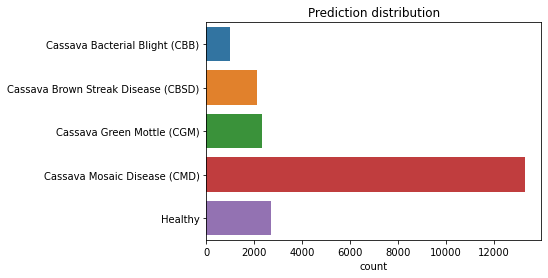

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1087
           1       0.85      0.81      0.83      2189
           2       0.84      0.82      0.83      2386
           3       0.96      0.97      0.97     13158
           4       0.74      0.77      0.76      2577

    accuracy                           0.90     21397
   macro avg       0.81      0.80      0.81     21397
weighted avg       0.89      0.90      0.90     21397



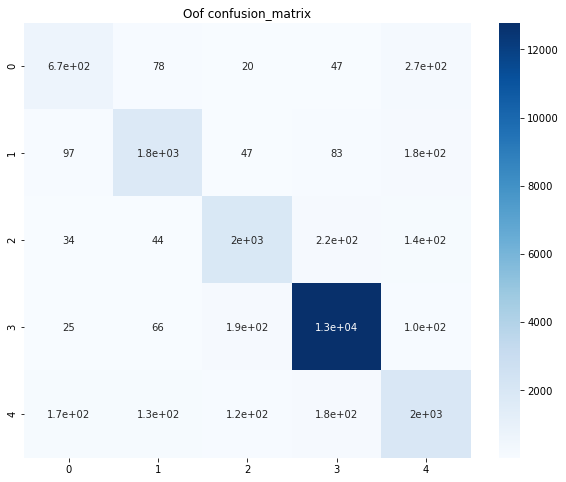

In [21]:
Y_pred = pickle.load(open("Y_pred.pkl", 'rb'))
oof_preds_df = pd.DataFrame(
    {
        "target": df["label"],
        "prediction": Y_pred.values.argmax(1),
        "logit": Y_pred.values.max(1),
        "file_path": df["file_path"],
    }
)
oof_preds_df.to_csv("oof_preds_df.csv", index=False)
display(oof_preds_df)


Y_pred_tta = pickle.load(open("Y_pred_tta.pkl", "rb"))
oof_preds_df = pd.DataFrame(
    {
        "target": df["label"],
        "prediction": Y_pred_tta.values.argmax(1),
        "logit": Y_pred_tta.values.max(1),
        "file_path": df["file_path"],
    }
)
oof_preds_df.to_csv("oof_preds_df_tta.csv", index=False)
display(oof_preds_df)


sns.countplot(y=sorted(oof_preds_df["prediction"].map(name_mapping)), orient="v")
plt.title("Prediction distribution")
plt.show()

print(metrics.classification_report(oof_preds_df["target"], oof_preds_df["prediction"]))

plt.figure(figsize=(10, 8))
sns.heatmap(
    metrics.confusion_matrix(oof_preds_df["target"], oof_preds_df["prediction"]),
    annot=True,
    cmap="Blues",
)
plt.title("Oof confusion_matrix")
plt.show()

In [22]:
#%load_ext tensorboard
#%tensorboard --logdir ./lightning_logs
#
#https://wandb.ai/anonamename/kaggle_cassava?workspace=user-anonamename